# Table of Contents

* [EDA](#one)

* [MODEL](#two)

* [SUBMISSION](#three)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score


import warnings
warnings.filterwarnings("ignore")

<a id="one" ></a>
# EDA


In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
original_data = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")
sample_submission_data = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

# Check the Shape of data
train_data.shape, test_data.shape

((20758, 18), (13840, 17))

In [4]:
train_data = train_data.drop("id", axis=1)
train_data = pd.concat([train_data, original_data], ignore_index=True)
train_data = train_data.drop_duplicates()
train_data.shape

(22845, 17)

In [5]:
num_cols = list(train_data.select_dtypes(exclude=['object']).columns)
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns)
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

num_cols_test = [col for col in num_cols_test if col not in ['id']]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols_test] = scaler.transform(test_data[num_cols_test])

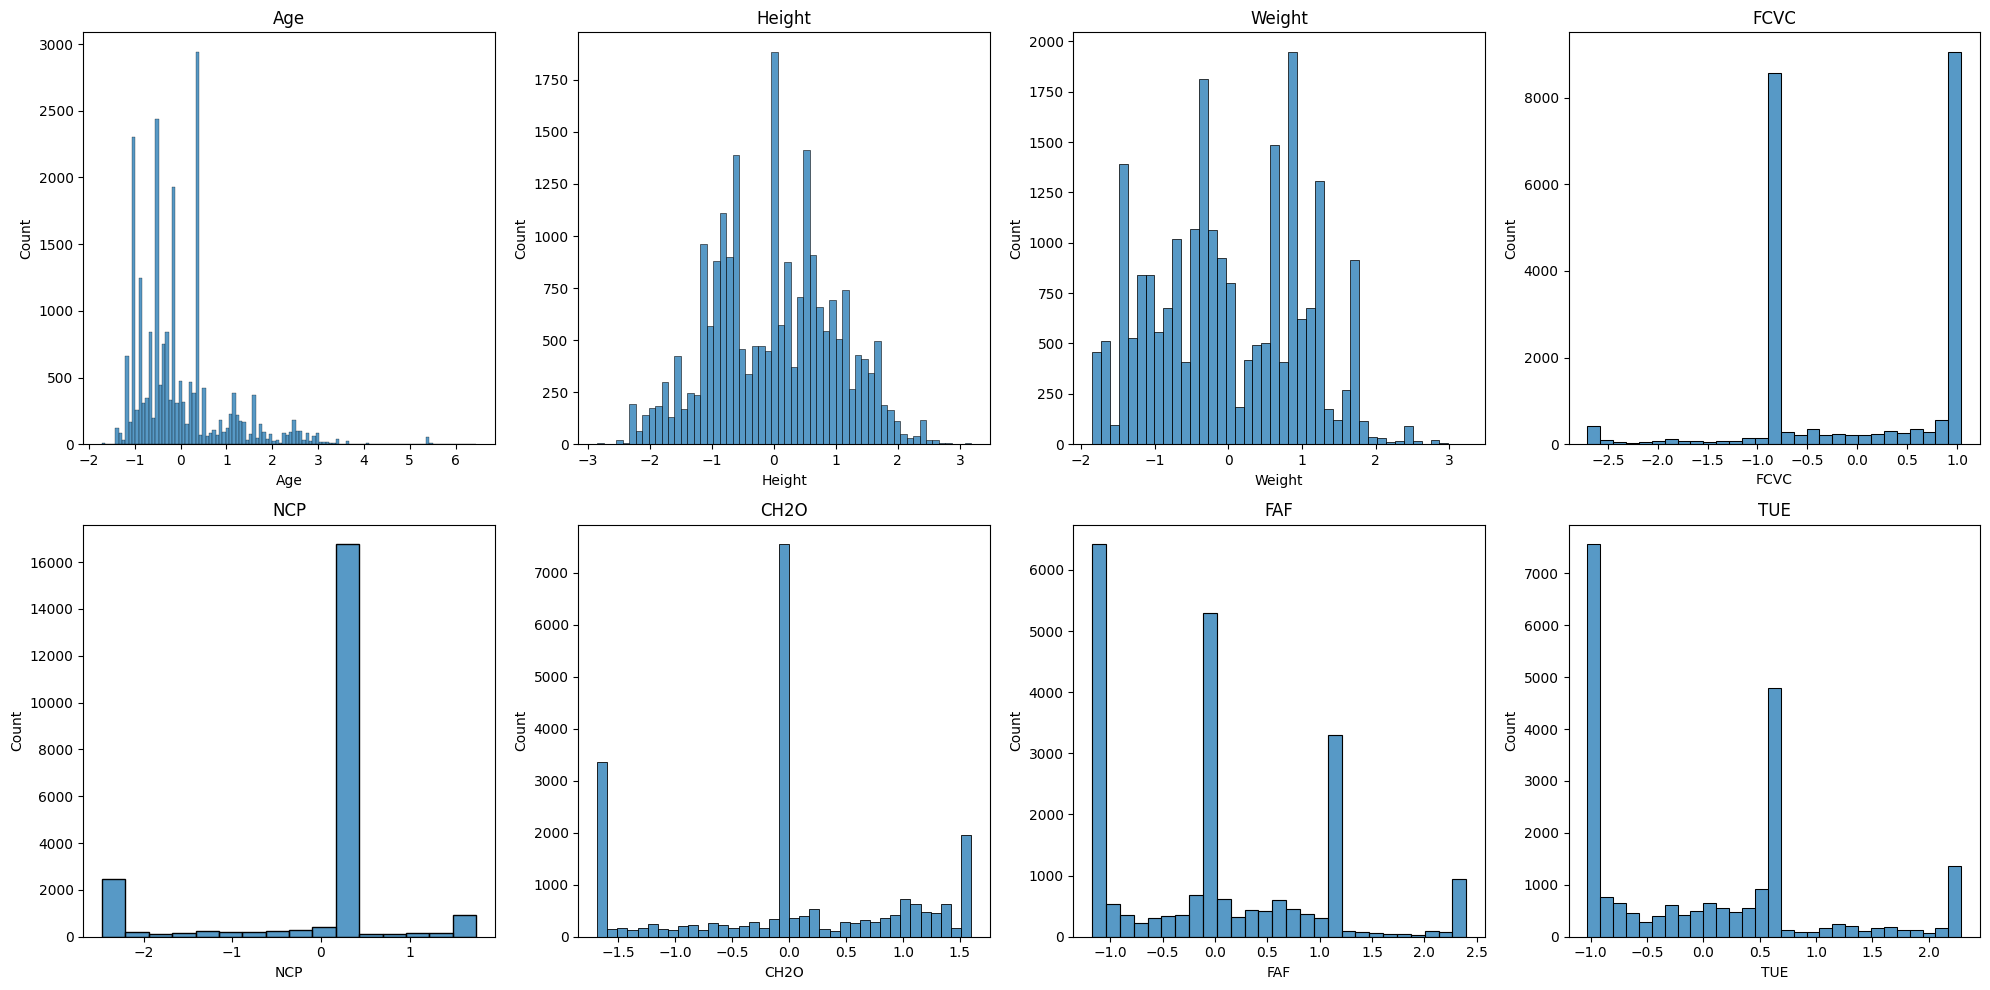

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

num = train_data.dtypes == float
df_num = train_data.loc[:, num]

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=False)

for i, ax in enumerate(axs.flat):
    column_name = df_num.columns[i]
    sns.histplot(data=df_num, x=column_name, ax=ax)
    ax.set_title(column_name)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

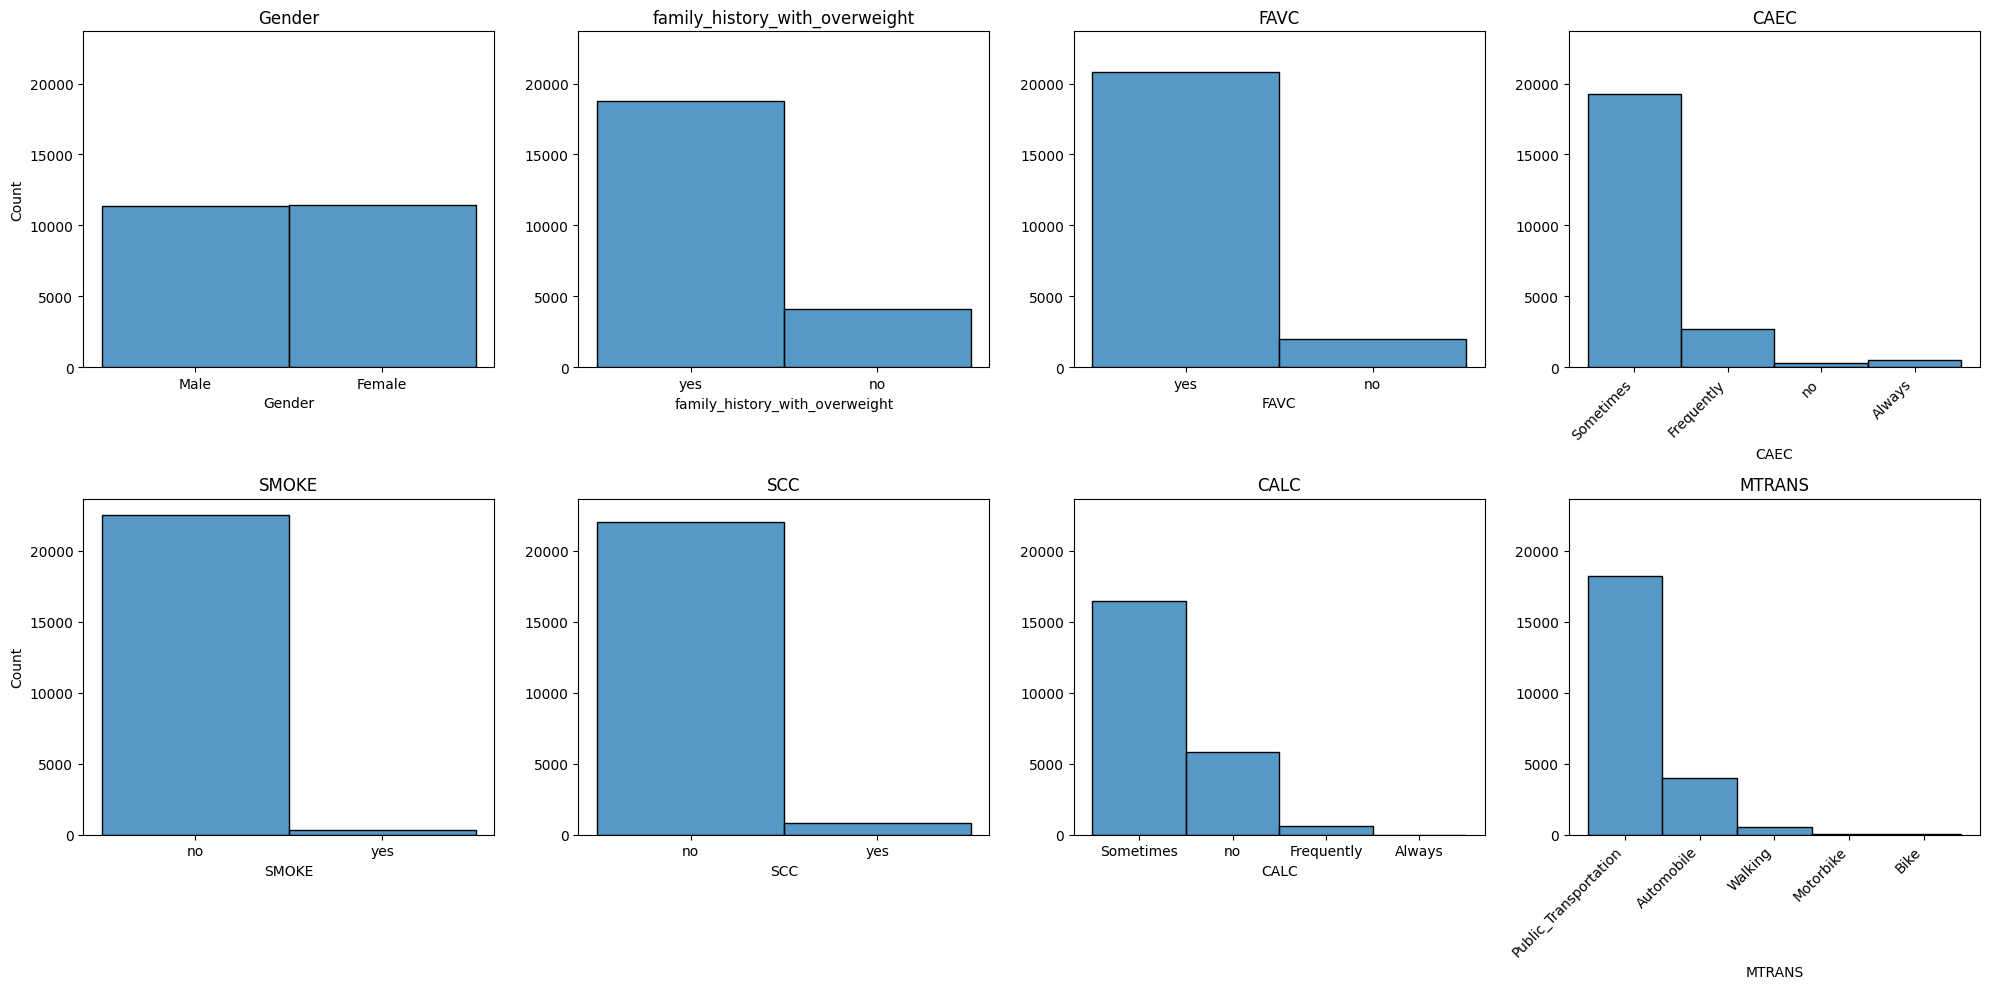

In [8]:
object = train_data.dtypes != float
df_object = train_data.loc[:, object]

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=True)

for i, ax in enumerate(axs.flat):
    column_name = df_object.columns[i]
    #sns.histplot(df_object.iloc[:, i], ax=ax)
    #sns.histplot(data=df_object, x=df_object.iloc[:, i], ax=ax)
    sns.histplot(data=df_object, x=column_name, ax=ax)
    ax.set_title(column_name)
    ax.set_ylabel('Count')
    ax.tick_params(axis='y', which='both', labelleft=True)
    if i in [3, 7]:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [9]:
#  object datatype columns encoding:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
object_columns = train_data.select_dtypes(include='object').columns.difference(['NObeyesdad'])

for col_name in object_columns:
    if train_data[col_name].dtypes=='object':
        train_data[col_name]=labelencoder.fit_transform(train_data[col_name])
        
for col_name in test_data.columns:
    if test_data[col_name].dtypes=='object':
        test_data[col_name]=labelencoder.fit_transform(test_data[col_name])

In [10]:
X = train_data.drop(['NObeyesdad'], axis=1)
y = train_data['NObeyesdad']
y = labelencoder.fit_transform(y)
X_test = test_data.drop(["id"],axis=1)

<a id="two" ></a>
# MODEL

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
param = {"objective": "multiclass",          
    "metric": "multi_logloss",          
    "verbosity": -1,                    
    "boosting_type": "gbdt",            
    "random_state": 42,       
    "num_class": 7,                     
    'learning_rate': 0.030962211546832760,  
    'n_estimators': 500,                
    'lambda_l1': 0.009667446568254372,  
    'lambda_l2': 0.04018641437301800,   
    'max_depth': 10,                    
    'colsample_bytree': 0.40977129346872643,  
    'subsample': 0.9535797422450176,   
    'min_child_samples': 26}

model_lgb = lgb.LGBMClassifier(**param,verbose=100)
model_lgb.fit(X_train, y_train)
pred_lgb = model_lgb.predict(X_val)
pred_proba = model_lgb.predict_proba(X_val)

In [13]:
import optuna

def objective(trial):
    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

In [14]:
num_classes = 7
pred_proba = pred_proba  # Example: replace with actual y_pred_proba
y_val = y_val  # Example: replace with actual y_val

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# # Get the best thresholds
best_thresholds = study.best_params
print("Best Thresholds:", best_thresholds)

[I 2024-02-29 10:04:12,169] A new study created in memory with name: no-name-bf0d4454-61ff-42ca-aeea-ec99b60f0c2b
[I 2024-02-29 10:04:12,175] Trial 0 finished with value: 0.8977894506456555 and parameters: {'threshold_0': 0.8568981565319955, 'threshold_1': 0.5460461191347036, 'threshold_2': 0.7727951469678406, 'threshold_3': 0.2570987095565376, 'threshold_4': 0.014216924097144146, 'threshold_5': 0.13043706404257227, 'threshold_6': 0.35015239815642696}. Best is trial 0 with value: 0.8977894506456555.
[I 2024-02-29 10:04:12,180] Trial 1 finished with value: 0.9039177062814621 and parameters: {'threshold_0': 0.8580135077380495, 'threshold_1': 0.66879945110235, 'threshold_2': 0.35401601776160085, 'threshold_3': 0.42155928833209266, 'threshold_4': 0.4137885759969553, 'threshold_5': 0.5691006305785274, 'threshold_6': 0.15819949561498503}. Best is trial 1 with value: 0.9039177062814621.
[I 2024-02-29 10:04:12,184] Trial 2 finished with value: 0.8971328518275333 and parameters: {'threshold_0':

Best Thresholds: {'threshold_0': 0.34800242149865346, 'threshold_1': 0.9208763327620062, 'threshold_2': 0.7885689206907749, 'threshold_3': 0.4199541524841749, 'threshold_4': 0.9068244832294761, 'threshold_5': 0.6741088251272233, 'threshold_6': 0.8906391940602973}


In [15]:
threshold= {'threshold_0': 0.724201213234911, 'threshold_1': 0.6161299800571379, 'threshold_2': 0.29138887902587174, 'threshold_3': 0.3145837593497076, 'threshold_4': 0.8469398340837189, 'threshold_5': 0.6800824438387787, 'threshold_6': 0.35886959729223455}

<a id="three" ></a>
# SUBMISSION

In [16]:
test_label = model_lgb.predict_proba(X_test)
test_label = apply_thresholds(test_label, threshold)

In [17]:
pred = labelencoder.inverse_transform(test_label)
submission = pd.DataFrame({'id': test_data.id, 'NObeyesdad': pred})
submission.to_csv('submission.csv', index=False)